In [1]:
"""
See intrinsic_imaging_alignment.ipynb for the processing required before using this notebook.

"""

'\nSee intrinsic_imaging_alignment.ipynb for the processing required before using this notebook.\n\n'

In [357]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os

from scipy.ndimage.filters import gaussian_filter1d, convolve1d, median_filter
from scipy.signal import butter, filtfilt, convolve, fftconvolve, medfilt
from matplotlib import pyplot as plt
from scipy.signal import correlate, savgol_filter
from matplotlib import patches
import scipy.ndimage as ni
import numpy as np
import pycircstat
import tifffile
import h5py

import cosmos.traces.trace_analysis_utils as utils
import cosmos.params.intrinsic_imaging_params as params

import matplotlib
matplotlib.rcParams.update({'xtick.major.pad': '2'})
matplotlib.rcParams.update({'ytick.major.pad': '2'})
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams['pdf.fonttype'] = 42 # truetype
matplotlib.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [358]:
params.DATASETS

{0: {'base': '/hdd1/Data/20180701/thy1gc_bars8_iso0-4_20hz_40trials_grating10_blank1/',
  'blank_length': 1,
  'cull_first_pulse': True,
  'filter_data': False,
  'hz': 10,
  'im_path': 'thy1gc_bars8_iso0-4_20hz_40trials_grating10_blank1_1-1.tif',
  'info': 'Test with Thy1Gcamp6s mouse. You can definitely see the relevant signal.',
  'led_px': array([150,  30]),
  'ndirs': 4,
  'sd_thresh': 1,
  'start_frame': 300,
  'stim_length': 10},
 1: {'base': '/media/Data/data/20180703/m72_bars8_700nm_iso0-5_20hz_150trials_grating10_blank1_1_1-1_scaled/',
  'blank_length': 1,
  'cull_first_pulse': True,
  'filter_data': False,
  'hz': 10,
  'im_path': 'm72_bars8_700nm_iso0-5_20hz_150trials_grating10_blank1_1_1-1.tif',
  'info': 'Initial 150 trial recording for m72. Conclusion: Worked well for orientation 2.',
  'led_px': array([150,  30]),
  'ndirs': 4,
  'sd_thresh': 1,
  'start_frame': 115,
  'stim_length': 10},
 2: {'base': '/media/Data/data/20180703/m943_bars8_700nm_iso0-5_20hz_150trials_gra

In [359]:
dataid = 4 # See cosmos/params/intrinsic_imaging_params for corresponding datasets.
datainfo = params.DATASETS[dataid]

date = datainfo['base'].split('/')[-3]
name = datainfo['base'].split('/')[-2]

base = '/home/izkula/Dropbox/cosmos/intrinsic_imaging_align/'
full_save_path = os.path.join(base, date, name)

In [376]:
import time
t0 = time.time()

chunks = []
for ind in range(4):
#     path = full_save_path + '/chunk{}.tif'.format(ind)
    path = full_save_path + '/chunk{}_smooth.tif'.format(ind)
    try:
        with tifffile.TiffFile(path) as tif:
            chunk = tif.asarray()

        chunks.append(chunk)
        print(time.time() - t0)
    except:
        chunks.append([])
        print('chunk {} does not exist'.format(ind))


chunk 0 does not exist
chunk 1 does not exist
0.036252498626708984
chunk 3 does not exist


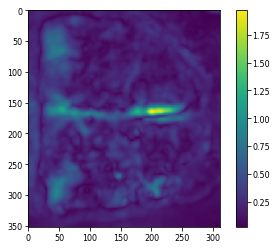

In [377]:
smap = np.max(np.abs(chunk[:,0:-1, 0:-1]), axis=0)
plt.imshow(smap)
plt.colorbar()

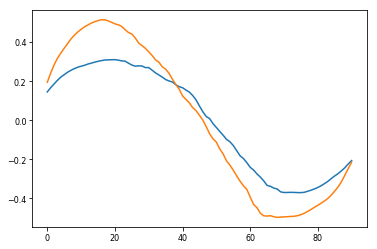

In [378]:
plt.plot(chunk[:, 75, 75])
plt.plot(chunk[:, 75, 60])

# plt.plot(chunk[10:-10, 60, 150])

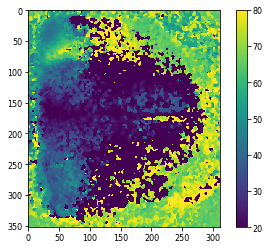

In [95]:
# import scipy.ndimage.filters as ff
# chunk = chunks[chunkid]
# chunk = ff.gaussian_filter(chunk, sigma=[1, 1.5, 1.5])
# phase_map = np.argmin(chunk[10:-10,0:-1, 0:-1], axis=0)
# # phase_map = -np.abs(phase_map - 70)
# phase_map[phase_map>82] = 0
# plt.imshow(phase_map, clim=[20, 80])
# plt.colorbar()

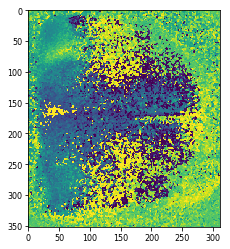

In [379]:
plt.imshow(phase_map)

In [244]:
diff = np.max(chunk, axis=0) - np.min(chunk, axis=0)
# diff[diff < 0.8] = 0.1
# diff[diff>0.1] = 1
diff[diff>.65] = 1
diff = diff**2
diff = diff[:-1, :-1]

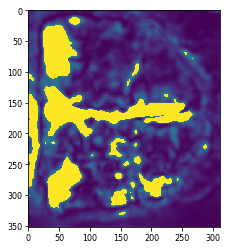

In [245]:
plt.imshow(diff)

In [350]:
alpha = np.min(chunk[:, :-1, :-1], axis=0)
alpha = np.abs(alpha)
alpha[alpha>.4] = 1


In [340]:
# import scipy.special
# alpha = scipy.special.expit((alpha-np.mean(alpha))*10)

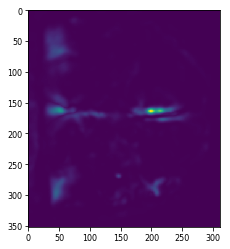

In [345]:
plt.imshow(alpha**3)

In [351]:
phase_map = np.argmin(chunk[10:-10,0:-1, 0:-1], axis=0)
phase_map = phase_map/100

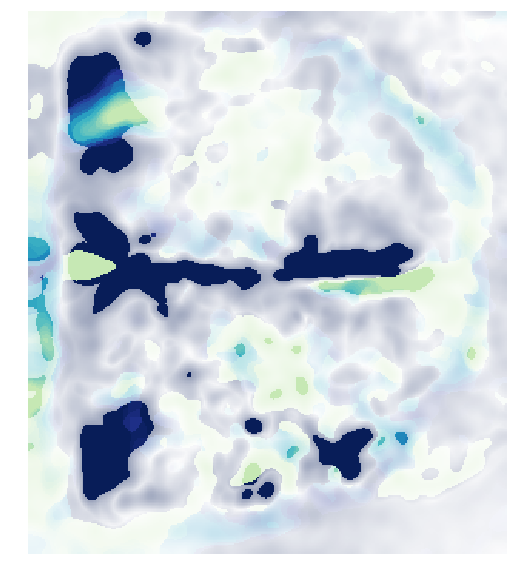

In [356]:
from matplotlib.colors import Normalize
vmin = .4
vmax = .8
colors = Normalize(vmin, vmax, clip=True)(phase_map)
cmap = plt.cm.YlGnBu_r
# cmap = plt.cm.plasma
# cmap = plt.cm.bwr
colors = cmap(colors)

# Now set the alpha channel to the one we created above
# colors[..., -1] = diff*phase_map**2
# colors[..., -1] = diff
colors[..., -1] = alpha #*phase_map
# colors[..., -1] = alpha**2



# Create the figure and image
# Note that the absolute values may be slightly different
fig, ax = plt.subplots(figsize=(10, 10))
greys = np.empty(phase_map.shape + (3,), dtype=np.uint8)
greys.fill(50)
#ax.imshow(greys)
ax.imshow(colors)
ax.set_axis_off()
impath = full_save_path + '/phase_alpha_{}_{}.png'.format(chunkid, cm)
plt.savefig(impath)

In [ ]:
### Current modified algorithm is to:
### - in Imagej, spatially fft bandpass filter the stack between 10 an d60
### - save that to the relevant dropbox folder (cosmos/intrinsic_imaging_align/...)
### - compute the peak-to-peak of each signal's time series
### - use that to generate an alpha mask, after some nonlinear scaling

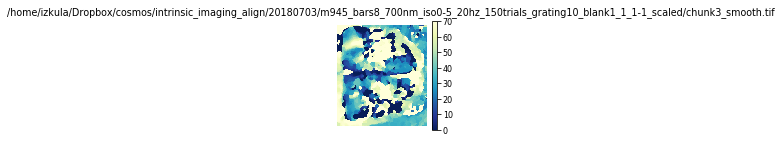

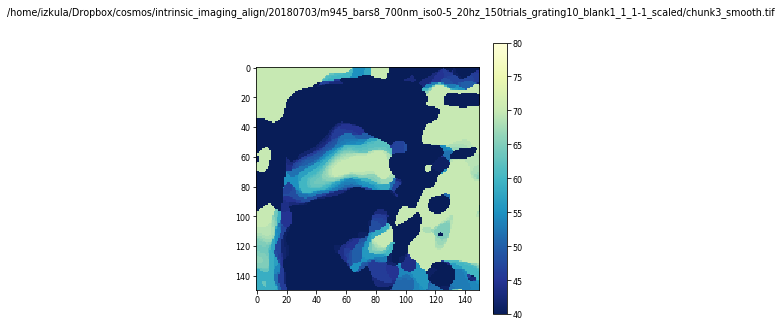

In [381]:
### Plot a phase map for alignment. 
# chunk = chunks[3]
chunkid = 2
chunk = chunks[chunkid]
# chunk = savgol_filter(chunk, 61, 3, axis=0)
cm='YlGnBu_r'
# cm = 'Greys'

plt.figure(figsize=(5, 5))
phase_map = np.argmin(chunk[10:-10,0:-1, 0:-1], axis=0)
pmap = medfilt(phase_map, 1)
plt.imshow(pmap, cmap=cm)
plt.colorbar()
# plt.clim([40, 80])
plt.suptitle(path)
impath = full_save_path + '/phase_{}_{}'.format(chunkid, cm)
plt.savefig(impath+'.png')
plt.axis('off')
plt.gcf().set_size_inches(w=2, h=2) # Control size of figure in inches
plt.savefig(impath+'.pdf', 
            transparent=True, rasterized=True, dpi=600) 

plt.figure(figsize=(5, 5))
plt.imshow(pmap[0:150,0:150], cmap=cm)
plt.colorbar()
# plt.clim([20, 80])
plt.clim([40, 80])

plt.suptitle(path)
impath = full_save_path + '/phasezoom_{}_{}.png'.format(chunkid, cm)
plt.savefig(impath)